## Learning to play Connect4 using a Recurrent Neural Network

In [2]:
import os

import numpy as np
import pandas as pd

First of all, we need to create the `Player()` class: this is a parent class for all the future *player* objects, provinding the essential information required to update the board state, to distinguish the two players and to check who has won the game.\
In fact, the class only contains the *constructor* function. 

In [3]:
class Player(object):
    def __init__(self, p=1, name='Player1'):
        self.player = p                     # number ID to produce the grid markers
        self.name = name                    # the name is used only for displaying purposes and to avoid misunderstandings
        if self.player == 1:
            self.marker = 1
        else:
            self.marker = -1
        self.target = int(4 * self.marker)  # +4 for player 1 and -4 for player 2

Every sub-class will inherit the previous features, as well as an additional function that determines the *child* player's next move. 

Then, we need to create a `Board()` class. Its main functions are displaying the grid for the game, finding all the possible valid positions for the tokens, keeping track of the tokens positioning during the game, checking for a winner.\
Notice that the player's move (from the *choice* variable derived from `Player.choice` in the code cell below) is just a single integer value: it represents the column where the player is placing the token.

In [4]:
class Board(object):
    def __init__(self, grid_size=(6,7)):
        # winner checking: 1 for player1, -1 for player 2 and 0 for "tie"
        self.winner = 0

        # grid parameters
        self.height = grid_size[0]
        self.width = grid_size[1]
        self.n_positions = self.height * self.width # number of initial positions

        # how many positions are left for each column
        self.column_n_pos = np.zeros(self.width, dtype=np.int16) + self.height
        # how many total positions are left
        self.n_pos_left = self.n_positions

        # initializing functions
        self.initialize_grids(grid_size)
        self.initialize_vectors()

    # function for initializing the grids used to keep track of the various positions
    def initialize_grids(self, grid_size):
        self.grid = np.zeros(shape=grid_size)                   # main grid
        self.valid_grid = np.zeros_like(self.grid, dtype=bool)  # grid for valid moves
        # initialize the whole first row as valid
        self.valid_grid[-1] = True
        # grid containing, for each column, the number of the column itself
        self.column_grid = np.array([[i for i in range(self.width)] for j in range(self.height)])
    
    # function for initializing vectors that will be used later for the update process
    # these vectors contain basically all the needed information about the grid state
    def initialize_vectors(self):
        self.vectors = []           # used to check if the winning condition is satisfied
        self.valid_vectors = []     # used to let the player make a valid move during the game
        self.column_vectors = []    # used to gather the information about the columns' state during the game

        # to check for a winner, the next loop goes through the whole grid looking for a filled "Connect4"
        # the view() method is only used to generate a new view of the arrays using the same data
        for j in range(self.width - 3): # exclude the last 3 columns
            for i, sub_row in enumerate(self.grid):
                # view the next 4 cells 
                grid_view = self.grid[i][j:j+4].view()   
                valid_view = self.valid_grid[i][j:j+4].view()
                column_view = self.column_grid[i][j:j+4].view()
        
                self.vectors.append(grid_view)
                self.valid_vectors.append(valid_view)
                self.column_vectors.append(column_view)

        # the column views are very similar to the previous ones, with the exception that we are using the 
        # transpose of the previous grid
        t_grid = self.grid.transpose()
        t_valid_grid = self.valid_grid.transpose()
        t_column_grid = self.column_grid.transpose()

        for j in range(self.height - 3): # exclude the last 3 rows
            for i, sub_col in enumerate(t_grid):
                # view the next 4 cells 
                grid_view = t_grid[i][j:j+4].view()   
                valid_view = t_valid_grid[i][j:j+4].view()
                column_view = t_column_grid[i][j:j+4].view()
        
                self.vectors.append(grid_view)
                self.valid_vectors.append(valid_view)
                self.column_vectors.append(column_view)

        # diagonal views are a bit different: we firstly divide the grids into smaller 4x4 sub-grids
        # then, using numpy's diagonal and flip methods, we take both the diagonal and the anti-diagonal
        # of these sub-grids
        for j in range(self.width - 3):
            for i in range(self.height - 3):
                sub_grid = self.grid[i:i+4, j:j+4]
                sub_valid_grid = self.valid_grid[i:i+4, j:j+4]
                sub_column_grid = self.column_grid[i:i+4, j:j+4]

                grid_diag = np.diagonal(sub_grid).view()
                grid_adiag = np.flipud(sub_grid).diagonal().view()
                valid_grid_diag = np.diagonal(sub_valid_grid).view()
                valid_grid_adiag = np.flipud(sub_valid_grid).diagonal().view()
                column_grid_diag = np.diagonal(sub_column_grid).view()
                column_grid_adiag = np.flipud(sub_column_grid).diagonal().view()

                self.vectors.append(grid_diag)
                self.vectors.append(grid_adiag)
                self.valid_vectors.append(valid_grid_diag)
                self.valid_vectors.append(valid_grid_adiag)
                self.column_vectors.append(column_grid_diag)
                self.column_vectors.append(column_grid_adiag)
                
    
    # function used to update the grid state, based on a Player's choice (the column to place the token in)
    def update_grid(self, Player):
        choice = Player.choice
        # row corresponding to the column choice 
        row = self.column_n_pos[choice] - 1 # since the enumeration starts from 0

        # first check: is there place for an additional token in that column?
        valid_columns = [i for i, v in enumerate(self.column_n_pos) if v != 0]
        if choice not in valid_columns:
            print(f'Error: this column number {choice} has no more valid positions!')
            return -1
        
        # update values in the main grid and the boolean one, using the player's marker (-1 or +1)
        self.grid[row,choice] = Player.marker
        self.valid_grid[row,choice] = False
        # the cell on top of the token becomes available
        if (row != 0):  # the last top row 
            self.valid_grid[row-1,choice] = True

        # update the number of moves left in the choice column
        if self.column_n_pos[choice] > 0:
            self.column_n_pos[choice] -= 1

        elif self.column_n_pos[choice] == 0:
            print(f'Error: the number of valid positions in column number {choice} is already 0!')
            return -1
        
        # update the total number of moves left
        if self.n_pos_left <= 0:
            print('Error : there are no positions left!')
            return -1
        else :
            self.n_pos_left -= 1

    
    def check_winner(self, Player):
        win = False
        for vector in self.vectors:
            if sum(vector) == Player.target:
                self.winner = Player.marker
                win = True
                break
        return win
    
    def display_grid(self):
        display = np.zeros_like(self.grid).astype(int).astype(str)
        for x, row in enumerate(display):
            for y, _ in enumerate(row):
                if(self.grid[x][y] == -1):
                    display[x][y] = 'O'
                elif(self.grid[x][y] == 1):
                     display[x][y] = 'X'
                elif(self.grid[x][y] == 0):
                     display[x][y] = ' '
        count = 0
        pattern = '   '
        for i in range(display.shape[1]):
            pattern += '+-----'
        pattern += '+'
        for row in display:
            txt = str(count)
            for cell in row:
                txt += '  |  ' + cell
            txt += '  |'
            print(txt)
            print(pattern)
            count += 1

        txt = '      '
        for i in range(display.shape[1]):
            txt += str(i) + '     '
        print(txt)

Below, we display the final resulting grid, with all the columns and row numbers as they were used in the code.

In [5]:
# empty grid
grid = Board()
grid.display_grid()

0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


__*First Player*: Human__\
The `HumanPlayer()` move is decided by the user itself.

In [6]:
class HumanPlayer(Player):
    def __init__(self, p=1, name='Human'):
        Player.__init__(self, p, name)
        self.player_type = 'Human'

    def move(self, Board):
        self.choice = int(input('Digit a column number to place your token.'))

__First Player: *Random*__\
The first player is a newbie and does not really know how to play. Therefore, it is playing randomly.\
The only constraints are provided by the conditions written inside the `Board()` class.

In [7]:
class RandomPlayer(Player):
    def __init__(self, p=1, name='Random'):
        Player.__init__(self, p, name)
        self.player_type = 'RandomAI'

    def move(self, Board):
        valid_columns = [i for i, v in enumerate(Board.column_n_pos) if v != 0]
        self.choice = np.random.choice(valid_columns)

Now we need to create the object able to instantiate all the other objects (`Board()` and `Player()`'s child classes) in order to get a full game of *Connect4*, being it simulated or actually played by the users.\
Note that this class requires a `game_type` string argument, defined as follows:
1. *`user-user`*: classic game 1v1, played by human users to overcome the boredom of the NNs' training process,
2. *`random-random`*: random player vs random player,
3. *`user-random`*: user versus random player (used mainly for debugging and problem checking),
4. *`user-simple`*: user versus simple hard-coded player,
5. *`simple-random`*: simple hard-coded player versus random player,
6. *`simple-simple`*: two simple hard-coded players playing against each other,
7. *`rnn-simple`*: recurrent network against simple hard-coded player,
8. *`rnn-rnn`*: two recurrent networks against each other (the core of the training process),
9. *`user-rnn`*: the final goal of this project $\rightarrow$ human player against a well-trained neural network.

In [8]:
import math
from IPython.display import clear_output

class Game(object):
    def __init__(self, game_type=None, verbose=False, pause=False, player1=None, player2=None):
        self.verbose = verbose              # shows the grid during the game
        self.pause = pause                  # used when playing against AI to visualize its moves      
        self.flag = False                   # used to break the loop at the end of the game
        self.Board = Board()                # generate the board and all the useful vectors
        
        self.game_record = {'player' : [], 
                            'choice' : [],  # dictionary used to save the game
                            'grid' : []}

        if (player1 != None) & (player2 != None):
                name1 = player1
                name2 = player2
        else:
                name1 = 'Player 1'
                name2 = 'Player 2'

        if game_type=='user-user':
            p1 = HumanPlayer(name=name1, p=1)
            p2 = HumanPlayer(name=name2, p=-1)
        
        if game_type=='user-random':
            p1 = HumanPlayer(name=name1, p=1)
            p2 = RandomPlayer(name=name2, p=2)

        if game_type=='random-random':
            p1 = RandomPlayer(name=name1, p=1)
            p2 = RandomPlayer(name=name2, p=2)

        # the starting player is always chosen at random 
        self.player_list = [p1, p2]
        np.random.shuffle(self.player_list)

        if self.verbose:
            print(f'Game Type: {game_type}')
            print(f'Player #1: {self.player_list[0].name}, {self.player_list[0].player_type}')
            print(f'Player #2: {self.player_list[1].name}, {self.player_list[1].player_type}')
    
    # this function runs through a game of Connect4 by first asking the player for a move, then updating the grid and,
    # finally, checking for a winner (eventually, it stops when reaching the total number of possible moves)
    def play_game(self, record=True):
        self.move_counter = 0
        for _ in range(math.ceil(self.Board.n_positions / 2)):   # main loop, one iteration per move by both players
            for player in self.player_list:            
                self.move_counter += 1
                # we save the grid before the grid update, so that the choice in the final dataset will
                # correspond to the choice made on that particular grid
                if record:
                    self.game_record['grid'].append((self.Board.grid.transpose()).tolist())
                    self.game_record['player'].append(player.name)
                # the board state (from the Board.update_grid() function) returns -1 if the player
                # makes an invalid move
                board_state = -1
                while board_state == -1:
                    if self.verbose:
                        print(f'Turn #{self.move_counter}: rock to {player.name}!')
                        print('+----------------------------------------------------------------+')
                        self.Board.display_grid()
                        clear_output(wait=True)
                        if (self.pause) & (player.player_type != 'Human') : input()
                    player.move(self.Board)
                    board_state = self.Board.update_grid(player)
                if record:
                    self.game_record['choice'].append(player.choice)
                self.win = self.Board.check_winner(player)      # check if the game has a winner
                if self.win:
                    if self.verbose:
                        print(f'The WINNER is {player.name}, {player.player_type}!!!')
                        print('+----------------------------------------------------------------+')
                        self.Board.display_grid()
                        if (self.pause) & (player.player_type != 'Human') : input()
                    self.Board.winner = player.player
                    break
            # check if there are no positions left
            if (self.win) | (self.Board.n_pos_left == 0):
                break
        
    def save_game(self):
        df = pd.DataFrame(self.game_record)
        columns = [f'col_{i}' for i in range(self.Board.width)]
        df[columns] = pd.DataFrame(df['grid'].tolist(), index=df.index)
        df.drop(columns='grid', inplace=True)
        return df

In [9]:
user_game_try = Game(game_type='user-user', verbose=True, player1='John', player2='Anna')

Game Type: user-user
Player #1: John, Human
Player #2: Anna, Human


In [10]:
user_game_try.play_game()

The WINNER is John, Human!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |     |     |     |  O  |  O  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  X  |  X  |  O  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


In [11]:
df = user_game_try.save_game()

In [12]:
df.head()

,player,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,John,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,Anna,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,John,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,Anna,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,John,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


To generate our training datasets, we only have to simulate the games multiple times, saving the results into a bigger `DataFrame()` object.\
During this part of the project, I encountered some troubles with the execution time: as you can see, building the dataset requires the concatenation of two dataframes and, as the loop goes on, the dataset gets bigger and bigger, resulting in a very slow compilation time, along with the inability for the `tqdm` bar to make a significative estimation of the remaining time.\
To speed things up, I decided to split the process into sub-sets of 1000 simulations each, concatenating the results with the bigger dataset only at the end of these subsets, then refreshing the smaller one.\
Despite not being a very elegant solution, it works quite well for this purpose.

In [267]:
from tqdm import tqdm
# simulating N AI-AI games
def simulation(n=100, game_type='random-random'):
    dataset = pd.DataFrame()
    i = 0
    if n <= 1000:
        for i in tqdm(range(n), desc='Simulating', bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}'):
            random_random = Game(game_type=game_type)       # initialize the game environment
            random_random.play_game()                       # play the game
            while not random_random.win:                    # repeat if the game ends in a draw
                random_random = Game(game_type=game_type)
                random_random.play_game()                   
            game = random_random.save_game()        
            game['move'] = game.index 
            game.index = [i] * len(game)
            dataset = pd.concat([dataset, game])
    else:
        j = 0
        for _ in tqdm(range(int(n / 1000)), desc='Simulating', bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}'):
            df = pd.DataFrame()
            for i in range(1000):
                random_random = Game(game_type=game_type)
                random_random.play_game()
                while not random_random.win:
                    random_random = Game(game_type=game_type)
                    random_random.play_game()       
                game = random_random.save_game()
                game['move'] = game.index
                game.index = [i + j] * len(game)
                df = pd.concat([df, game])
            j += i + 1
            dataset = pd.concat([dataset, df])
        
    print('Saving: ...')
    dataset.to_csv(f'simulations/simulation_{game_type}_{n}.csv')
    # rearrange the columns order
    return dataset[['player', 'move', 'choice', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6']]

In [268]:
dataset = simulation(n=10000, game_type='random-random')

Simulating: 100%|███████████████| 10/10 [01:45<00:00, 10.54s/it]


Saving: ...


In [ ]:
dataset

,player,move,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,Player 1,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,Player 2,1,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,Player 1,2,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,Player 2,3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,Player 1,4,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
9999,Player 1,23,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, -1.0, 1.0, -1.0, -1.0]","[0.0, 1.0, 1.0, -1.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, 1.0, -1.0, -1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, -1.0, 1.0, 1.0, 1.0, -1.0]"
9999,Player 2,24,5,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, -1.0, 1.0, -1.0, -1.0]","[0.0, 1.0, 1.0, -1.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, 1.0, -1.0, -1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, -1.0, 1.0, 1.0, 1.0, -1.0]"
9999,Player 1,25,3,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, -1.0, 1.0, -1.0, -1.0]","[0.0, 1.0, 1.0, -1.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, 1.0, -1.0, -1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, -1.0, 1.0, 1.0, 1.0, -1.0]"
9999,Player 2,26,2,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, -1.0, 1.0, -1.0, -1.0]","[0.0, 1.0, 1.0, -1.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 1.0, -1.0, -1.0]","[0.0, 1.0, -1.0, -1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, -1.0, 1.0, 1.0, 1.0, -1.0]"


Now let's explore this dataset a bit.\
For example, let's start with plotting the distribution of the moves number.

In [269]:
import matplotlib.pyplot as plt
%matplotlib inline

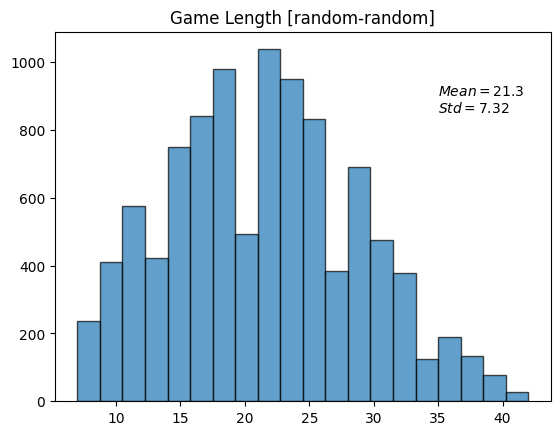

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42], dtype=int64)

In [270]:
row_count = dataset.groupby(level=0).size()

plt.hist(row_count, bins=20, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Game Length [random-random]')
plt.text(35, 900, f'$Mean = {row_count.mean().round(2)}$')
plt.text(35, 850, f'$Std = {row_count.std().round(2)}$')
plt.show()

np.sort(row_count.unique())

As expected, the absolute frequency follows a Gaussian distribution, with the minimum value being 7.\
\
We now check whether one player won more times than the other, and also whether being the initial player may have provided an advantage on the final outcome of the match.

In [280]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [297]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

Player 1 winrate =  0.5014
Player 2 winrate =  0.4986
Starter winrate  =  0.5602


The random players' winrates are basically identical, while it seems that starting the game first can give a certain advantage.